# Multi-class classification based on Softmax and Cross-Entropy using pytorch

## import libraries

In [321]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

## load data

In [322]:
directory_data  = './data/'
filename_data   = 'assignment_06_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

*************************************************
size of x_train : (20000, 32, 32)
size of y_train : (20000,)
*************************************************
size of x_test : (8000, 32, 32)
size of y_test : (8000,)
*************************************************
number of training image : 20000
height of training image : 32
width of training image : 32
*************************************************
number of testing image : 8000
height of testing image : 32
width of testing image : 32
*************************************************


## number of classes

In [323]:
print('*************************************************')
print('number of classes :', len(set(y_train)))
print('*************************************************')

*************************************************
number of classes : 10
*************************************************


## hyper-parameters

In [324]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 100
size_minibatch  = 50
learning_rate   = 0.001
weight_decay    = 0.0001

## custom data loader for the PyTorch framework

In [325]:
class dataset(Dataset):
    
    def __init__(self, image, label):
        
        self.image  = image
        self.label  = label.astype(np.long)
    
    def __getitem__(self, index):
        
        image   = self.image[index, :, :]
        label   = self.label[index, ]

        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.LongTensor([label])

        return image, label
    
    def __len__(self):
        
        return self.image.shape[0]

    def collate_fn(self, batch):
        images  = list()
        labels  = list()

        for b in batch:
            images.append(b[0])
            labels.append(b[1])

        images  = torch.stack(images, dim=0)
        labels  = torch.stack(labels, dim=0).squeeze()

        return images, labels
        

## construct datasets and dataloaders for training and testing

In [326]:
dataset_train   = dataset(x_train, y_train)
dataset_test    = dataset(x_test, y_test)

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_train.collate_fn)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_test.collate_fn)

## shape of the data when using the data loader

In [327]:
image, label    = next(iter(dataloader_train))
print('************************************************************')
print('size of mini-batch of the image:', image.shape)
print('************************************************************')
print('size of mini-batch of the label:', label.shape)
print('************************************************************')

************************************************************
size of mini-batch of the image: torch.Size([50, 1, 32, 32])
************************************************************
size of mini-batch of the label: torch.Size([50])
************************************************************


## class for the neural network 

In [328]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.feature    = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=1, padding=2, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=4, stride=1, padding=2, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            # nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1, bias=True),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(4096, 10, bias=True)
        )

        self.network    = nn.Sequential(
            self.feature,
            nn.Flatten(),
            self.classifier,
        )

        self.initialize()


    def initialize(self):

        for m in self.network.modules():

            if isinstance(m, nn.Conv2d):

                nn.init.constant_(m.weight, 0.01)
                nn.init.constant_(m.bias, 1)

            elif isinstance(m, nn.Linear):

                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 1)


    def forward(self, input):

        output = self.network(input)

        return output

    

## build network

In [329]:
classifier  = Classifier().to(device)
optimizer   = torch.optim.SGD(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

## print the defined neural network

In [330]:
print(classifier)

Classifier(
  (feature): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(16, 64, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=10, bias=True)
  )
  (network): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
      (3): Conv2d(16, 64, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ReLU()
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Sequential(
      (0): Linear(in_features=4096, out_

## compute the prediction

In [331]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss

In [332]:
def compute_loss(prediction, label):

    criterion   = nn.CrossEntropyLoss()
    loss        = criterion(prediction, label)
    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [333]:
def compute_accuracy(prediction, label):
    # ================================================================================ 
    # complete the function body 
    
    
    bCorrect = prediction.argmax(axis=1) == label
    accuracy = (torch.sum(bCorrect) / len(label)).detach().cpu().numpy()
    # ================================================================================ 

    return accuracy

## variables for the learning curve

In [334]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train and test

In [335]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    loss_train_epoch        = []
    accuracy_train_epoch    = []

    classifier.train()

    for index_batch, (image_train, label_train) in enumerate(dataloader_train):

        image_train = image_train.to(device)
        label_train = label_train.to(device)
        prediction_train                = compute_prediction(classifier, image_train)
        loss_train, loss_value_train    = compute_loss(prediction_train, label_train)
        accuracy_train                  = compute_accuracy(prediction_train, label_train)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        loss_train_epoch.append(loss_value_train)
        accuracy_train_epoch.append(accuracy_train)

    loss_mean_train[i]      = np.mean(loss_train_epoch)
    loss_std_train[i]       = np.std(loss_train_epoch)

    accuracy_mean_train[i]  = np.mean(accuracy_train_epoch)
    accuracy_std_train[i]   = np.std(accuracy_train_epoch)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    loss_test_epoch        = []
    accuracy_test_epoch    = []

    classifier.eval()

    for index_batch, (image_test, label_test) in enumerate(dataloader_test):

        image_test = image_test.to(device)
        label_test = label_test.to(device)
        
        prediction_test             = compute_prediction(classifier, image_test)
        loss_test, loss_value_test  = compute_loss(prediction_test, label_test)
        accuracy_test               = compute_accuracy(prediction_test, label_test)

        loss_test_epoch.append(loss_value_test)
        accuracy_test_epoch.append(accuracy_test)

    loss_mean_test[i]      = np.mean(loss_test_epoch)
    loss_std_test[i]       = np.std(loss_test_epoch)

    accuracy_mean_test[i]  = np.mean(accuracy_test)
    accuracy_std_test[i]   = np.std(accuracy_test)

100%|██████████| 100/100 [03:43<00:00,  2.24s/it]


## plot curve

In [336]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [337]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [338]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [339]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [340]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [341]:
def function_result_01():

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [342]:
def function_result_02():

    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [343]:
def function_result_03():
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [344]:
def function_result_04():
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [345]:
def function_result_05():
    
    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [346]:
def function_result_06():
    
    data_last = get_data_last(accuracy_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [347]:
def function_result_07():
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [348]:
def function_result_08():
    
    data_last = get_data_last(accuracy_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [349]:
def function_result_09():
    
    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [350]:
def function_result_10():
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---

## # 01. plot the training loss curve (mean, std)

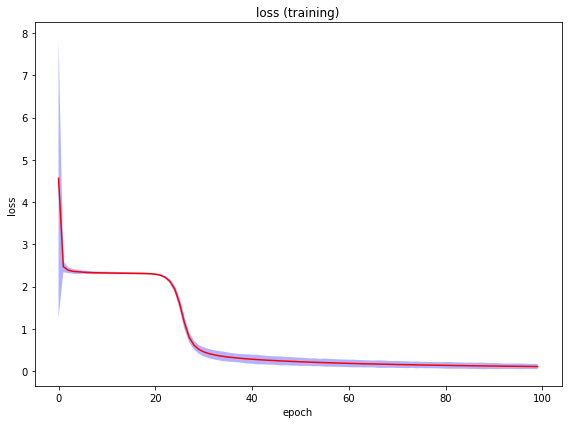

In [351]:
function_result_01()

## # 02. plot the training accuracy curve (mean, std)

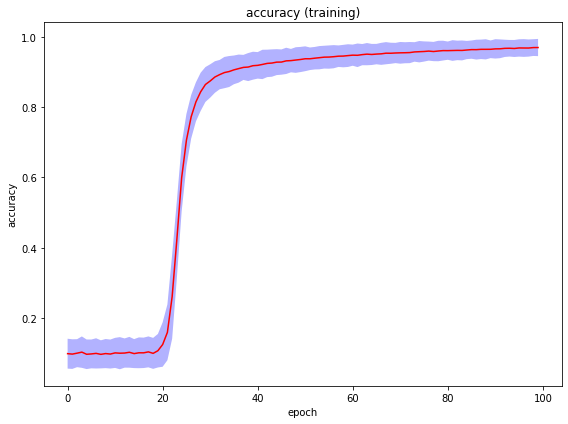

In [352]:
function_result_02()

## # 03. plot the testing loss curve (mean, std)

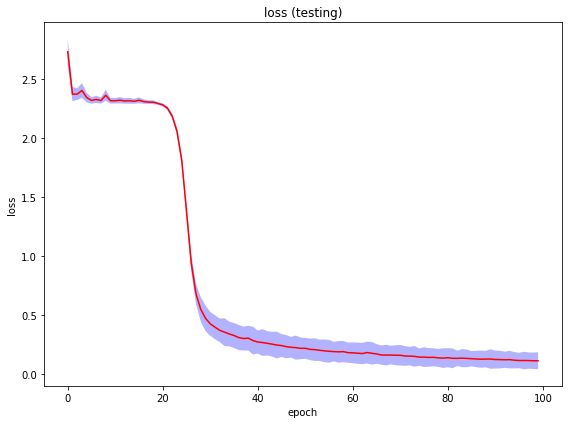

In [353]:
function_result_03()

## # 04. plot the testing accuracy curve (mean, std)

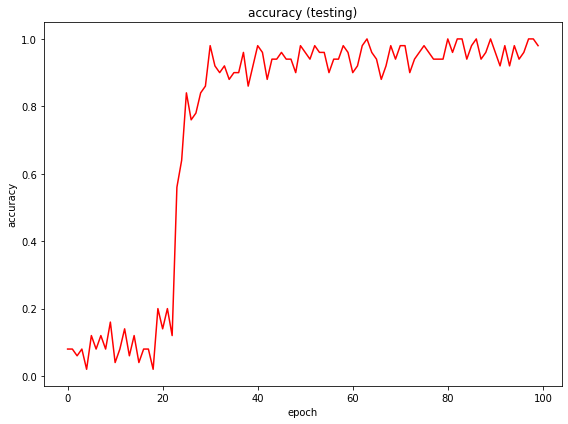

In [354]:
function_result_04()

## # 05. print the training (mean) loss over batches at last 10 epochs

In [355]:
function_result_05()

index =  0, value = 0.1185715740
index =  1, value = 0.1168564844
index =  2, value = 0.1153811919
index =  3, value = 0.1140573763
index =  4, value = 0.1130456737
index =  5, value = 0.1124232282
index =  6, value = 0.1109543592
index =  7, value = 0.1094667158
index =  8, value = 0.1081376066
index =  9, value = 0.1070007382


## # 06. print the training (mean) accuracy over batches at last 10 epochs

In [356]:
function_result_06()

index =  0, value = 0.9654999375
index =  1, value = 0.9656999111
index =  2, value = 0.9669998884
index =  3, value = 0.9672499299
index =  4, value = 0.9665998816
index =  5, value = 0.9680998921
index =  6, value = 0.9679499865
index =  7, value = 0.9678499103
index =  8, value = 0.9691499472
index =  9, value = 0.9692999125


## # 07. print the testing (mean) loss over batches at last 10 epochs

In [357]:
function_result_07()

index =  0, value = 0.1253212660
index =  1, value = 0.1247053505
index =  2, value = 0.1232386449
index =  3, value = 0.1244158529
index =  4, value = 0.1193922593
index =  5, value = 0.1167929794
index =  6, value = 0.1168310070
index =  7, value = 0.1162946166
index =  8, value = 0.1146568488
index =  9, value = 0.1149045518


## # 08. print the testing (mean) accuracy over batches at last 10 epochs

In [358]:
function_result_08()

index =  0, value = 0.9599999785
index =  1, value = 0.9199999571
index =  2, value = 0.9799999595
index =  3, value = 0.9199999571
index =  4, value = 0.9799999595
index =  5, value = 0.9399999976
index =  6, value = 0.9599999785
index =  7, value = 1.0000000000
index =  8, value = 1.0000000000
index =  9, value = 0.9799999595


## # 09. print the best training (mean) accuracy within the last 10 epochs

In [359]:
function_result_09()

best training accuracy = 0.9692999125


## # 10. print the best testing (mean) accuracy within the last 10 epochs

In [360]:
function_result_10()

best testing accuracy = 1.0000000000
